In [1]:
!pip install tensorflow


In [2]:
#importing the libraries
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression,SGDClassifier,LinearRegression
from sklearn.metrics import precision_score,recall_score,f1_score,confusion_matrix
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR, SVC  # Add SVC here
from datetime import datetime
from sklearn.metrics import accuracy_score


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import classification_report

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd

# Step 1: Read both Excel files into DataFrames
icc_df = pd.read_csv('/content/drive/MyDrive/files/matches_final.csv')
odi_df = pd.read_csv('/content/drive/MyDrive/files/ODI_Match_info.csv')

# Step 2: Create a new column to indicate the source
icc_df['importance'] = 'ICC'
odi_df['importance'] = 'ODI'

# Assuming 'team1' is the column you want to match on
combined_df = pd.merge(icc_df, odi_df, on=['team1','team2','date','city','venue','toss_winner','toss_decision','winner_runs','winner_wickets','winner','importance'], how='outer', suffixes=('_icc', '_odi'))

#Step 4: Assign weights/importance levels
combined_df['weight'] = combined_df['importance'].map({'ICC': 2, 'ODI': 1})

# Display the combined DataFrame
combined_df


,season,team1,team2,date,match_number,venue,city,toss_winner,toss_decision,player_of_match,umpire1,umpire2,reserve_umpire,match_referee,winner,winner_runs,winner_wickets,match_type,importance,weight
0,2023/24,England,New Zealand,05-10-2023,1.0,Narendra Modi Stadium,Ahmedabad,New Zealand,field,R Ravindra,HDPK Dharmasena,Nitin Menon,Sharfuddoula,J Srinath,New Zealand,NaN,9.0,Group,ICC,2
1,2023/24,Pakistan,Netherlands,06-10-2023,2.0,Rajiv Gandhi International Stadium,Hyderabad,Netherlands,field,Saud Shakeel,AT Holdstock,CM Brown,PR Reiffel,JJ Crowe,Pakistan,81.0,NaN,Group,ICC,2
2,2023/24,Afghanistan,Bangladesh,07-10-2023,3.0,Himachal Pradesh Cricket Association Stadium,Dharamsala,Bangladesh,field,Mehedi Hasan Miraz,JS Wilson,HDPK Dharmasena,M Erasmus,AJ Pycroft,Bangladesh,NaN,6.0,Group,ICC,2
3,2023/24,South Africa,Sri Lanka,07-10-2023,4.0,Arun Jaitley Stadium,Delhi,Sri Lanka,field,AK Markram,RK Illingworth,Sharfuddoula,AG Wharf,J Srinath,South Africa,102.0,NaN,Group,ICC,2
4,2023/24,Australia,India,08-10-2023,5.0,MA Chidambaram Stadium,Chennai,Australia,bat,KL Rahul,CB Gaffaney,RA Kettleborough,AT Holdstock,RB Richardson,India,NaN,6.0,Group,ICC,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2477,NaN,South Africa,Australia,16-11-2023,NaN,Eden Gardens,Kolkata,South Africa,field,NaN,NaN,NaN,NaN,NaN,Australia,0.0,0.0,NaN,ODI,1
2478,NaN,India,South Africa,19-11-2023,NaN,Narendra Modi Stadium,Ahmedabad,South Africa,bat,NaN,NaN,NaN,NaN,NaN,India,0.0,0.0,NaN,ODI,1
2479,NaN,India,South Africa,19-11-2023,NaN,Narendra Modi Stadium,Ahmedabad,India,bat,NaN,NaN,NaN,NaN,NaN,India,0.0,0.0,NaN,ODI,1
2480,NaN,India,South Africa,19-11-2023,NaN,Narendra Modi Stadium,Ahmedabad,South Africa,field,NaN,NaN,NaN,NaN,NaN,India,0.0,0.0,NaN,ODI,1


In [ ]:
df = combined_df

In [ ]:
df.shape

(2482, 19)

In [ ]:
df.columns

Index(['season', 'team1', 'team2', 'date', 'match_number', 'venue', 'city',
       'toss_winner', 'toss_decision', 'player_of_match', 'umpire1', 'umpire2',
       'reserve_umpire', 'match_referee', 'winner', 'winner_runs',
       'winner_wickets', 'match_type', 'importance'],
      dtype='object')

In [ ]:
df.head(2)

,season,team1,team2,date,match_number,venue,city,toss_winner,toss_decision,player_of_match,umpire1,umpire2,reserve_umpire,match_referee,winner,winner_runs,winner_wickets,match_type,importance
0,2023/24,England,New Zealand,05-10-2023,1.0,Narendra Modi Stadium,Ahmedabad,New Zealand,field,R Ravindra,HDPK Dharmasena,Nitin Menon,Sharfuddoula,J Srinath,New Zealand,NaN,9.0,Group,ICC
1,2023/24,Pakistan,Netherlands,06-10-2023,2.0,Rajiv Gandhi International Stadium,Hyderabad,Netherlands,field,Saud Shakeel,AT Holdstock,CM Brown,PR Reiffel,JJ Crowe,Pakistan,81.0,NaN,Group,ICC


In [ ]:
data = df.copy()

In [ ]:
# Dropping the columns which are not related to the prediction of the final teams
data.drop(columns=['match_number','season','player_of_match','umpire1','umpire2','reserve_umpire','match_referee','match_type'],axis=1,inplace=True)

In [ ]:
# Adding the column based on winning or losing of team1
# If team1 wins then the value is 1
data['win_target'] = np.where(data['team1'] == data['winner'], 1, 0)

In [ ]:
data.columns

Index(['team1', 'team2', 'date', 'venue', 'city', 'toss_winner',
       'toss_decision', 'winner', 'winner_runs', 'winner_wickets',
       'importance', 'win_target'],
      dtype='object')

In [ ]:
data.shape

(2482, 12)

In [ ]:
data.head(1)

,team1,team2,date,venue,city,toss_winner,toss_decision,winner,winner_runs,winner_wickets,importance,win_target
0,England,New Zealand,05-10-2023,Narendra Modi Stadium,Ahmedabad,New Zealand,field,New Zealand,NaN,9.0,ICC,0


In [ ]:
print(data['team1'].unique())
print(len(data['team1'].unique()))

['England' 'Pakistan' 'Afghanistan' 'South Africa' 'Australia'
 'New Zealand' 'Sri Lanka' 'Bangladesh' 'Netherlands' 'India' nan 'Nepal'
 'West Indies' 'Scotland' 'United Arab Emirates' 'Oman' 'Zimbabwe'
 'United States of America' 'Ireland' 'Canada' 'Namibia' 'Jersey'
 'Papua New Guinea' 'Hong Kong' 'Kenya' 'Africa XI' 'Bermuda']
27


In [ ]:
print(data['team2'].unique())
print(len(data['team2'].unique()))

['New Zealand' 'Netherlands' 'Bangladesh' 'Sri Lanka' 'India' 'Pakistan'
 'Australia' 'England' 'South Africa' 'Afghanistan' nan 'Ireland' 'Nepal'
 'West Indies' 'United States of America' 'Zimbabwe' 'Oman' 'Scotland'
 'United Arab Emirates' 'Papua New Guinea' 'Jersey' 'Canada' 'Namibia'
 'Hong Kong' 'Kenya' 'Bermuda' 'Asia XI' 'ICC World XI']
28


In [ ]:
# Create a mapping dictionary for team1
team1_mapping = {
    'England': 1, 'Pakistan': 2, 'Afghanistan': 3, 'South Africa': 4, 'Australia': 5, 'New Zealand': 6, 'Sri Lanka': 7, 'Bangladesh': 8, 'Netherlands': 9, 'India': 10,
    'Nepal': 11, 'West Indies': 12, 'Scotland': 13, 'United Arab Emirates': 14, 'Oman': 15, 'Zimbabwe': 16, 'United States of America': 17, 'Ireland': 18,
    'Canada': 19, 'Namibia': 20, 'Jersey': 21, 'Papua New Guinea': 22, 'Hong Kong': 23, 'Kenya': 24, 'Africa XI': 25, 'Bermuda': 26
}

# Manually encode 'team1'
data['team1'] = data['team1'].map(team1_mapping)

In [ ]:
team2_mapping = {
    'England': 1, 'Pakistan': 2, 'Afghanistan': 3, 'South Africa': 4, 'Australia': 5, 'New Zealand': 6, 'Sri Lanka': 7, 'Bangladesh': 8, 'Netherlands': 9, 'India': 10,
    'Nepal': 11, 'West Indies': 12, 'Scotland': 13, 'United Arab Emirates': 14, 'Oman': 15, 'Zimbabwe': 16, 'United States of America': 17, 'Ireland': 18, 'Canada': 19,
    'Namibia': 20, 'Jersey': 21, 'Papua New Guinea': 22, 'Hong Kong': 23, 'Kenya': 24, 'Africa XI': 25, 'Bermuda': 26, 'Asia XI': 27, 'ICC World XI': 28
}

# Manually encode 'team2'
data['team2'] = data['team2'].map(team2_mapping)

In [ ]:
label_encoder = LabelEncoder()

In [ ]:
column_to_encode = data.select_dtypes(exclude='number').columns
for column in column_to_encode:
    data[column] = data[column].astype(str)
    data[column] = label_encoder.fit_transform(data[column])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2482 entries, 0 to 2481
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   team1           2481 non-null   float64
 1   team2           2481 non-null   float64
 2   date            2482 non-null   int64  
 3   venue           2482 non-null   int64  
 4   city            2482 non-null   int64  
 5   toss_winner     2482 non-null   int64  
 6   toss_decision   2482 non-null   int64  
 7   winner          2482 non-null   int64  
 8   winner_runs     2459 non-null   float64
 9   winner_wickets  2458 non-null   float64
 10  importance      2482 non-null   int64  
 11  win_target      2482 non-null   int64  
dtypes: float64(4), int64(8)
memory usage: 252.1 KB


In [ ]:
data.describe()

,team1,team2,date,venue,city,toss_winner,toss_decision,winner,winner_runs,winner_wickets,importance,win_target
count,2481.000000,2481.000000,2482.000000,2482.000000,2482.000000,2482.000000,2482.000000,2482.000000,2459.000000,2458.000000,2482.000000,2482.000000
mean,8.326884,8.185409,1030.385576,163.838437,74.804593,14.258662,0.491136,14.154714,35.953233,2.770545,0.981467,0.522965
std,5.519244,5.473349,591.243874,81.320228,46.567007,8.010823,0.500828,8.151542,55.885081,3.243891,0.134897,0.499573
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,4.000000,517.250000,100.000000,33.000000,7.000000,0.000000,7.000000,0.000000,0.000000,1.000000,0.000000
50%,7.000000,7.000000,1033.500000,174.000000,74.000000,16.000000,0.000000,16.000000,0.000000,0.000000,1.000000,1.000000
75%,12.000000,12.000000,1536.750000,237.000000,112.000000,22.000000,1.000000,21.000000,60.000000,6.000000,1.000000,1.000000
max,26.000000,28.000000,2055.000000,297.000000,145.000000,27.000000,2.000000,27.000000,317.000000,10.000000,1.000000,1.000000


In [ ]:
# correlation matrix
corr_matrix = data.corr()
corr_matrix

,team1,team2,date,venue,city,toss_winner,toss_decision,winner,winner_runs,winner_wickets,importance,win_target
team1,1.000000,0.258319,-0.002455,-0.104930,-0.013093,0.115023,0.084042,0.107526,-0.065819,0.057508,0.073733,-0.156378
team2,0.258319,1.000000,-0.033210,-0.038884,-0.010188,0.135389,0.033646,0.128746,0.082380,-0.065597,0.062558,0.133806
date,-0.002455,-0.033210,1.000000,-0.043779,-0.006248,-0.018475,-0.024148,-0.005172,-0.004577,0.003570,0.009540,0.019038
venue,-0.104930,-0.038884,-0.043779,1.000000,0.087372,-0.024814,-0.031719,-0.032180,0.022709,0.021109,-0.011957,0.024761
city,-0.013093,-0.010188,-0.006248,0.087372,1.000000,0.026686,-0.042114,-0.031497,0.006754,0.025461,0.041900,-0.017298
toss_winner,0.115023,0.135389,-0.018475,-0.024814,0.026686,1.000000,0.061352,0.402484,0.022660,-0.013970,0.057775,0.032758
toss_decision,0.084042,0.033646,-0.024148,-0.031719,-0.042114,0.061352,1.000000,0.050589,0.007461,-0.016418,-0.026296,-0.008852
winner,0.107526,0.128746,-0.005172,-0.032180,-0.031497,0.402484,0.050589,1.000000,-0.043122,-0.069658,0.044029,-0.139441
winner_runs,-0.065819,0.082380,-0.004577,0.022709,0.006754,0.022660,0.007461,-0.043122,1.000000,-0.541595,-0.160681,0.287793
winner_wickets,0.057508,-0.065597,0.003570,0.021109,0.025461,-0.013970,-0.016418,-0.069658,-0.541595,1.000000,-0.095961,-0.239069


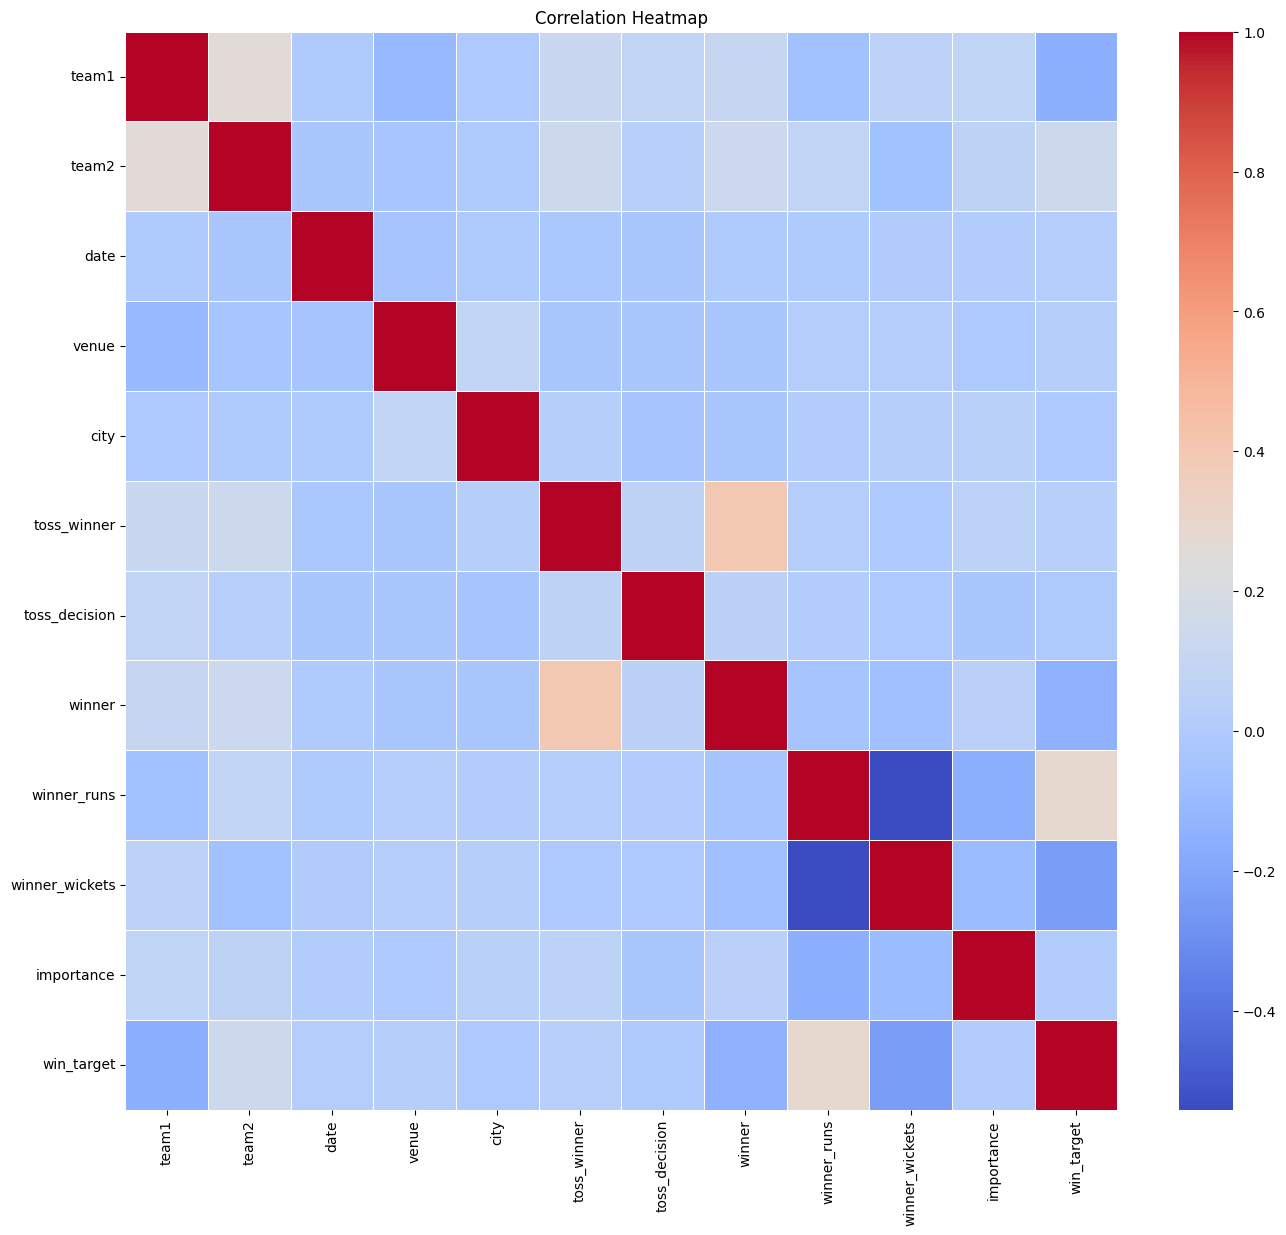

In [ ]:
# heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

Checking the null values and correcting it

In [ ]:
null_vals = data.isnull().sum()
null_vals[null_vals != 0].sort_values(ascending=False)

winner_wickets    24
winner_runs       23
team1              1
team2              1
dtype: int64

In [ ]:
data['winner_wickets'].fillna(0, inplace=True)
data['winner_runs'].fillna(0, inplace=True)

data['team1'].fillna(30, inplace=True)
data['team2'].fillna(31, inplace=True)

In [ ]:
null_vals = data.isnull().sum()
null_vals[null_vals != 0].sort_values(ascending=False)

Series([], dtype: int64)

Splitting the data

In [ ]:
x = data[['team1','team2','city','venue','toss_winner','toss_decision','winner_runs', 'importance', 'winner_wickets']]
y = data['win_target']

In [ ]:
modified_data = x

In [ ]:
x_train, x_test_valid, y_train, y_test_valid = train_test_split(x, y, test_size=0.35, random_state=42)
x_valid, x_test, y_valid, y_test = train_test_split(x_test_valid, y_test_valid, test_size=0.5, random_state=42)

In [ ]:
# Shape of the data considered for the above 3
print(x_train.shape,x_valid.shape,x_test.shape)
print(y_train.shape,y_test_valid.shape,y_test.shape)

(1613, 9) (434, 9) (435, 9)
(1613,) (869,) (435,)


In [ ]:
# Standardising the data
train_scaler = StandardScaler().fit(x_train)
X_train_scaled = train_scaler.transform(x_train)

valid_scaler = StandardScaler().fit(x_train)
X_valid_scaled = valid_scaler.transform(x_valid)

test_scaler = StandardScaler().fit(x_train)
X_test_scaled = test_scaler.transform(x_test)


In [ ]:
# Dictionary of different models with their parameters for Team Prediction
model_dict = {
    'RandomForestClassifier': {"model": RandomForestClassifier(random_state=42),
                               "params": {'n_estimators': list(range(5, 50, 5)), 'max_depth': list(range(1, 10, 2))}},
    'XGBClassifier': {"model": XGBClassifier(), "params": {'n_estimators': list(range(10, 800, 100)), 'learning_rate': [0.001, 0.01, 0.1]}},
    'DecisionTreeClassifier': {"model": DecisionTreeClassifier(), "params": {'max_depth': list(range(1, 10, 2))}},  # Add Decision Tree
}


In [ ]:
# Evaluation function of model
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score

def evaluate_team_composition(model, model_name, x_train_scaled, y_train, x_test_scaled, y_test, X_valid_scaled, y_valid, param_grid=None):
    print(f"Model performance for {model_name}")

    # Grid Search
    if param_grid:
        start_time = datetime.now()
        grid_search = GridSearchCV(model, param_grid, cv=3, n_jobs=-1, scoring='accuracy')
        grid_search.fit(x_train_scaled, y_train)
        best_params = grid_search.best_params_
        end_time = datetime.now()
        training_time = (end_time - start_time).total_seconds()
        print("Best Hyperparameters:", best_params)
        print("Grid Search Training Time (seconds):", training_time)
    else:
        best_params = None
        training_time = None

    # Fit the model with or without grid search
    if best_params:
        model = model.set_params(**best_params)
    model.fit(x_train_scaled, y_train)

    # Predictions
    y_train_pred = model.predict(x_train_scaled)
    y_test_pred = model.predict(x_test_scaled)
    y_valid_pred = model.predict(X_valid_scaled)

    # Evaluate team composition predictions
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    valid_accuracy = accuracy_score(y_valid, y_valid_pred)

    train_precision = precision_score(y_train, y_train_pred, average='binary')  # Change 'binary' based on your problem
    test_precision = precision_score(y_test, y_test_pred, average='binary')
    valid_precision = precision_score(y_valid, y_valid_pred, average='binary')

    train_recall = recall_score(y_train, y_train_pred, average='binary')
    test_recall = recall_score(y_test, y_test_pred, average='binary')
    valid_recall = recall_score(y_valid, y_valid_pred, average='binary')

    return {
        "Model": model,  # Return the model itself
        "Best Parameters": best_params,
        "Training Time (seconds)": training_time,
        "Train Accuracy": train_accuracy,
        "Test Accuracy": test_accuracy,
        "Validation Accuracy": valid_accuracy,
        "Train Precision": train_precision,
        "Test Precision": test_precision,
        "Validation Precision": valid_precision,
        "Train Recall": train_recall,
        "Test Recall": test_recall,
        "Validation Recall": valid_recall
    }

# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=["Model", "Best Parameters", "Training Time (seconds)",
                                   "Train Accuracy", "Test Accuracy", "Validation Accuracy",
                                   "Train Precision", "Test Precision", "Validation Precision",
                                   "Train Recall", "Test Recall", "Validation Recall"])


In [ ]:
# Iterate over the models
for model_name, model_info in model_dict.items():
    model = model_info["model"]
    params = model_info["params"]

    # Call the evaluate_team_composition function
    results = evaluate_team_composition(model, model_name, X_train_scaled, y_train, X_test_scaled, y_test, X_valid_scaled, y_valid, param_grid=params)

    # Append the results to the DataFrame
    results_df = results_df.append({
        "Model": model_name,
        "Best Parameters": results["Best Parameters"],
        "Training Time (seconds)": results["Training Time (seconds)"],
        "Train Accuracy": accuracy_score(y_train, results["Model"].predict(X_train_scaled)),
        "Test Accuracy": accuracy_score(y_test, results["Model"].predict(X_test_scaled)),
        "Validation Accuracy": accuracy_score(y_valid, results["Model"].predict(X_valid_scaled)),
        "Train Precision": results["Train Precision"],
        "Test Precision": results["Test Precision"],
        "Validation Precision": results["Validation Precision"],
        "Train Recall": results["Train Recall"],
        "Test Recall": results["Test Recall"],
        "Validation Recall": results["Validation Recall"]
    }, ignore_index=True)



Model performance for RandomForestClassifier
Best Hyperparameters: {'max_depth': 9, 'n_estimators': 45}
Grid Search Training Time (seconds): 5.503076
Model performance for XGBClassifier


<ipython-input-35-0fd65c5b9266>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Best Hyperparameters: {'learning_rate': 0.01, 'n_estimators': 510}
Grid Search Training Time (seconds): 27.96521
Model performance for DecisionTreeClassifier
Best Hyperparameters: {'max_depth': 9}
Grid Search Training Time (seconds): 0.094555


<ipython-input-35-0fd65c5b9266>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-35-0fd65c5b9266>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


In [ ]:
results_df

,Model,Best Parameters,Training Time (seconds),Train Accuracy,Test Accuracy,Validation Accuracy,Train Precision,Test Precision,Validation Precision,Train Recall,Test Recall,Validation Recall
0,RandomForestClassifier,"{'max_depth': 9, 'n_estimators': 45}",5.503076,0.905146,0.751724,0.764977,0.910820,0.773756,0.770925,0.907583,0.746725,0.777778
1,XGBClassifier,"{'learning_rate': 0.01, 'n_estimators': 510}",27.965210,0.884067,0.751724,0.751152,0.911139,0.781395,0.762332,0.862559,0.733624,0.755556
2,DecisionTreeClassifier,{'max_depth': 9},0.094555,0.847489,0.717241,0.691244,0.875628,0.754808,0.695279,0.825829,0.685590,0.720000


In [ ]:
# Fitting ANN on the data
def train_and_evaluate_dnn_classifier(x, y):
    # Split the data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    # Standardize the features
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    # Define and train the neural network model
    model = Sequential([
        Dense(units=64, activation='relu', input_dim=x_train.shape[1]),
        Dense(units=32, activation='relu'),
        Dense(units=1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Set verbose=1 to see training progress for each epoch
    model.fit(x_train_scaled, y_train, epochs=10, batch_size=10, validation_split=0.1, verbose=1)

    # Evaluate the model on the testing set
    evaluation_results = model.evaluate(x_test_scaled, y_test, verbose=1)

    # Display evaluation metrics
    precision = evaluation_results[1]
    accuracy = evaluation_results[1]

    print(f"Precision: {round(precision * 100, 2)}")
    print(f"Accuracy: {round(accuracy * 100, 2)}")

    # Optionally, display more detailed classification report
    predictions = model.predict(x_test_scaled)
    binary_predictions = (predictions > 0.5).astype(int)

    print("\nClassification Report:")
    print(classification_report(y_test, binary_predictions))

    return model

# Assuming df is your DataFrame, and x and y are defined as specified
x = data[['team1','team2','city','venue','toss_winner','toss_decision','winner_runs', 'importance', 'winner_wickets']]
y = data['win_target']

trained_dnn_classifier = train_and_evaluate_dnn_classifier(x, y)

Epoch 1/10
179/179 [==============================] - 2s 3ms/step - loss: 0.6451 - accuracy: 0.6215 - val_loss: 0.6542 - val_accuracy: 0.5829
Epoch 2/10
179/179 [==============================] - 0s 2ms/step - loss: 0.6078 - accuracy: 0.6562 - val_loss: 0.6396 - val_accuracy: 0.6231
Epoch 3/10
179/179 [==============================] - 0s 3ms/step - loss: 0.5937 - accuracy: 0.6719 - val_loss: 0.6324 - val_accuracy: 0.6382
Epoch 4/10
179/179 [==============================] - 0s 1ms/step - loss: 0.5861 - accuracy: 0.6797 - val_loss: 0.6369 - val_accuracy: 0.6231
Epoch 5/10
179/179 [==============================] - 0s 1ms/step - loss: 0.5769 - accuracy: 0.6870 - val_loss: 0.6274 - val_accuracy: 0.6432
Epoch 6/10
179/179 [==============================] - 0s 1ms/step - loss: 0.5710 - accuracy: 0.6954 - val_loss: 0.6310 - val_accuracy: 0.6382
Epoch 7/10
179/179 [==============================] - 0s 2ms/step - loss: 0.5673 - accuracy: 0.6932 - val_loss: 0.6280 - val_accuracy: 0.6181
Epoch 

In [ ]:
# Fitting the best model
best_model_name = results_df.sort_values(by=["Training Time (seconds)", "Train Accuracy",	"Test Accuracy",	"Validation Accuracy",	"Train Precision",	"Test Precision",	"Validation Precision",	"Train Recall",	"Test Recall",	"Validation Recall"], ascending=False).iloc[0]['Model']

# Select the best model from model_dict
best_model_info = model_dict[best_model_name]
best_model = best_model_info["model"]
best_params = best_model_info["params"]

# Fit the best model with the best parameters on your training data
best_model.fit(x_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=510, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Predicting whether the team1 is winning based on the model we fit
y_pred = best_model.predict(x)

In [ ]:
y_pred

array([0, 1, 0, ..., 1, 1, 1])

In [ ]:
modified_data['predicted_column'] = y_pred
modified_data.head(5)

<ipython-input-42-f6d6fda9648c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modified_data['predicted_column'] = y_pred


,team1,team2,city,venue,toss_winner,toss_decision,winner_runs,importance,winner_wickets,predicted_column
0,1.0,6.0,3,164,16,1,0.0,0,9.0,0
1,2.0,9.0,69,205,15,1,81.0,0,0.0,1
2,3.0,8.0,43,104,4,1,0.0,0,6.0,0
3,4.0,7.0,40,12,22,1,102.0,0,0.0,1
4,5.0,10.0,31,136,3,0,0.0,0,6.0,0


In [ ]:
modified_data

,team1,team2,city,venue,toss_winner,toss_decision,winner_runs,importance,winner_wickets,predicted_column
0,1.0,6.0,3,164,16,1,0.0,0,9.0,0
1,2.0,9.0,69,205,15,1,81.0,0,0.0,1
2,3.0,8.0,43,104,4,1,0.0,0,6.0,0
3,4.0,7.0,40,12,22,1,102.0,0,0.0,1
4,5.0,10.0,31,136,3,0,0.0,0,6.0,0
...,...,...,...,...,...,...,...,...,...,...
2477,4.0,5.0,86,76,21,1,0.0,1,0.0,0
2478,10.0,4.0,3,164,21,0,0.0,1,0.0,1
2479,10.0,4.0,3,164,9,0,0.0,1,0.0,1
2480,10.0,4.0,3,164,21,1,0.0,1,0.0,1


Based on the points table prediciting the semi finals match between INDIA VS NEW ZEALAND, SOUTH AFRICA VS AUSTRALIA

In [ ]:
# India vs New Zealand
india_label = 10
new_zealand_label = 6

# Filter for teams like 'New Zealand' or 'India'
NZvsIn = modified_data[((modified_data['team1'] == india_label) & (modified_data['team2'] == new_zealand_label)) | ((modified_data['team1'] == new_zealand_label) & (modified_data['team2'] == india_label))]


<ipython-input-44-06cc8f1ccf1d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modified_data['predicted_column'] = y_pred


In [ ]:
NZvsIn

,team1,team2,city,venue,toss_winner,toss_decision,winner_runs,importance,winner_wickets,predicted_column
20,6.0,10.0,43,104,9,1,0.0,0,4.0,0
186,10.0,6.0,70,106,16,1,90.0,1,0.0,0
189,6.0,10.0,119,230,9,1,0.0,1,8.0,0
190,10.0,6.0,69,207,9,0,12.0,1,0.0,0
207,10.0,6.0,34,99,16,1,0.0,1,0.0,0
209,10.0,6.0,65,224,16,1,0.0,1,0.0,0
212,10.0,6.0,7,79,16,1,0.0,1,7.0,0
451,6.0,10.0,98,21,16,1,0.0,1,5.0,0
456,6.0,10.0,7,78,9,1,22.0,1,0.0,0
459,6.0,10.0,65,223,16,1,0.0,1,4.0,0


In [ ]:
#india : 10
#new_zealand : 6
NZvsIn['team1'].value_counts()

10.0    32
6.0     25
Name: team1, dtype: int64



*   Since India has high winning percentage, India wins the match.




In [ ]:
# South Africa vs Australia
south_africa_label = 4
australia = 5

# Filter for teams like 'New Zealand' or 'India'
southvsaus = modified_data[((modified_data['team1'] == south_africa_label) & (modified_data['team2'] == australia)) | ((modified_data['team1'] == australia) & (modified_data['team2'] == south_africa_label))]


In [ ]:
southvsaus

,team1,team2,city,venue,toss_winner,toss_decision,winner_runs,importance,winner_wickets,predicted_column
9,4.0,5.0,93,27,3,1,134.0,0,0.0,0
52,4.0,5.0,74,263,3,1,122.0,1,0.0,0
55,4.0,5.0,27,252,3,1,164.0,1,0.0,0
58,4.0,5.0,115,226,3,1,111.0,1,0.0,0
62,5.0,4.0,15,146,21,1,123.0,1,0.0,0
65,4.0,5.0,15,146,3,1,0.0,1,3.0,0
441,4.0,5.0,115,227,21,1,0.0,1,6.0,0
443,4.0,5.0,15,145,3,0,0.0,1,6.0,0
447,4.0,5.0,107,30,21,0,74.0,1,0.0,0
507,5.0,4.0,94,182,21,0,10.0,1,0.0,0


In [ ]:
#south_africa : 4
#australia : 5

southvsaus['team1'].value_counts()

4.0    32
5.0    26
Name: team1, dtype: int64



*   South Africa wins the game since it has more winnning percentage.



Predicting the final match of ICC World Cup

In [ ]:
# India vs South Africa
india_label = 10
south_africa_label = 4

# Filter for teams like 'New Zealand' or 'India'
indvssouthaf = modified_data[((modified_data['team1'] == india_label) & (modified_data['team2'] == south_africa_label)) | ((modified_data['team1'] == south_africa_label) & (modified_data['team2'] == india_label))]


In [ ]:
indvssouthaf

,team1,team2,city,venue,toss_winner,toss_decision,winner_runs,importance,winner_wickets,predicted_column
36,10.0,4.0,86,297,9,0,243.0,0,0.0,0
225,4.0,10.0,40,13,9,1,0.0,1,7.0,0
226,4.0,10.0,121,114,21,0,0.0,1,7.0,0
227,4.0,10.0,93,28,9,1,9.0,1,0.0,0
347,4.0,10.0,25,177,9,1,4.0,1,0.0,0
351,10.0,4.0,107,31,9,0,0.0,1,7.0,0
352,4.0,10.0,107,31,21,0,31.0,1,0.0,0
543,10.0,4.0,126,257,21,0,0.0,1,6.0,0
711,4.0,10.0,27,251,9,1,0.0,1,8.0,0
713,10.0,4.0,112,247,21,1,73.0,1,0.0,0


In [ ]:
#india : 10
#south_africa : 4
indvssouthaf['team1'].value_counts()

10.0    28
4.0     21
Name: team1, dtype: int64



**India wins the ICC World Cup 2023 based on the winning percentage from the previous matches which model predicted.**